In [1]:
from collections import OrderedDict
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import epsilon_0, speed_of_light
from scipy.integrate import solve_ivp
from shapely.geometry import Polygon
from skfem import Basis, ElementTriP0, Mesh
from skfem.io import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict

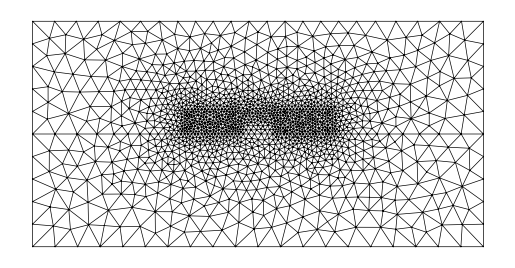

In [4]:
w_sim = 4
h_clad = 1
h_box = 1
w_core_1 = 0.45
w_core_2 = 0.46
gap = 0.4
h_core = 0.22
offset_heater = 2.2
h_heater = 0.14
w_heater = 2

wavelength = 1.55
k0 = 2 * np.pi / wavelength

polygons = OrderedDict(
    core_1=Polygon(
        [
            (-w_core_1 - gap / 2, 0),
            (-w_core_1 - gap / 2, h_core),
            (-gap / 2, h_core),
            (-gap / 2, 0),
        ]
    ),
    core_2=Polygon(
        [
            (w_core_2 + gap / 2, 0),
            (w_core_2 + gap / 2, h_core),
            (gap / 2, h_core),
            (gap / 2, 0),
        ]
    ),
    clad=Polygon(
        [
            (-w_sim / 2, 0),
            (-w_sim / 2, h_clad),
            (w_sim / 2, h_clad),
            (w_sim / 2, 0),
        ]
    ),
    box=Polygon(
        [
            (-w_sim / 2, 0),
            (-w_sim / 2, -h_box),
            (w_sim / 2, -h_box),
            (w_sim / 2, 0),
        ]
    ),
)

resolutions = dict(
    core_1={"resolution": 0.03, "distance": 1},
    core_2={"resolution": 0.03, "distance": 1},
)

mesh = from_meshio(
    mesh_from_OrderedDict(polygons, resolutions, filename="mesh.msh", default_resolution_max=0.2)
)
mesh.draw().show()

C:\Users\blow\AppData\Local\Temp\ipykernel_34460\3693127342.py:7: DeprecationWarning: The behavior of passing an array directly to `show` is deprecated and will be removed in the future. Use `plot` instead.
  modes_both[0].show(modes_both[0].E.real, direction="x")


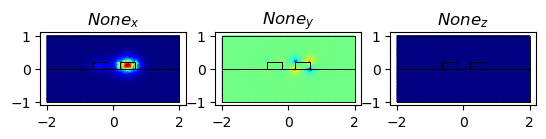

C:\Users\blow\AppData\Local\Temp\ipykernel_34460\3693127342.py:8: DeprecationWarning: The behavior of passing an array directly to `show` is deprecated and will be removed in the future. Use `plot` instead.
  modes_both[1].show(modes_both[1].E.real, direction="x")


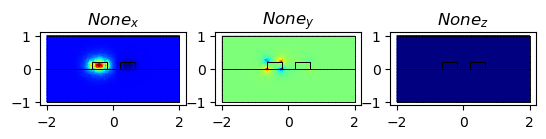

Refractive index of symmetric and assymetric mode: (2.3711213710792847+0j) ,  (2.349170333123299+0j)
Maximum power transfer after 35.30584756647811 um prop length


In [5]:
basis0 = Basis(mesh, ElementTriP0(), intorder=4)

epsilon = basis0.zeros() + 1.444**2
epsilon[basis0.get_dofs(elements=("core_1", "core_2"))] = 3.4777**2
# basis0.plot(epsilon, colorbar=True).show()
modes_both = compute_modes(basis0, epsilon, wavelength=wavelength, mu_r=1, num_modes=2)
modes_both[0].show(modes_both[0].E.real, direction="x")
modes_both[1].show(modes_both[1].E.real, direction="x")
print(
    "Refractive index of symmetric and assymetric mode:",
    modes_both[0].n_eff,
    ", ",
    modes_both[1].n_eff,
)
# https://www.fiberoptics4sale.com/blogs/wave-optics/directional-couplers
print(
    f"Maximum power transfer after {np.pi / (2 * np.pi / wavelength * np.real(modes_both[0].n_eff - modes_both[1].n_eff))} um prop length"
)

Effective refractive index of the mode of the first waveguide (2.349540399191198+0j)


C:\Users\blow\AppData\Local\Temp\ipykernel_34460\185950769.py:6: DeprecationWarning: The behavior of passing an array directly to `show` is deprecated and will be removed in the future. Use `plot` instead.
  modes_1[0].show(modes_1[0].E.real, direction="x")


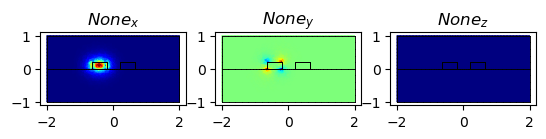

Effective refractive index of the mode of the second waveguide (2.370660339027542+0j)


C:\Users\blow\AppData\Local\Temp\ipykernel_34460\185950769.py:13: DeprecationWarning: The behavior of passing an array directly to `show` is deprecated and will be removed in the future. Use `plot` instead.
  modes_2[0].show(modes_2[0].E.real, direction="x")


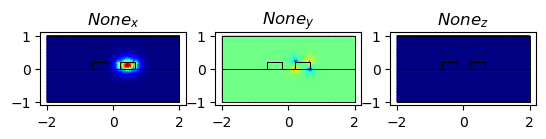

In [6]:
epsilon = basis0.zeros() + 1.444**2
epsilon[basis0.get_dofs(elements="core_1")] = 3.4777**2
# basis0.plot(epsilon, colorbar=True).show()
modes_1 = compute_modes(basis0, epsilon, wavelength=wavelength, mu_r=1, num_modes=1)
print("Effective refractive index of the mode of the first waveguide", modes_1[0].n_eff)
modes_1[0].show(modes_1[0].E.real, direction="x")

epsilon_2 = basis0.zeros() + 1.444**2
epsilon_2[basis0.get_dofs(elements="core_2")] = 3.4777**2
# basis0.plot(epsilon_2, colorbar=True).show()
modes_2 = compute_modes(basis0, epsilon_2, wavelength=wavelength, mu_r=1, num_modes=1)
print("Effective refractive index of the mode of the second waveguide", modes_2[0].n_eff)
modes_2[0].show(modes_2[0].E.real, direction="x")

In [7]:
length = 200
ts = np.linspace(0, length, 1000)

overlap [[1.        +0.j 0.01395496+0.j]
 [0.01395496+0.j 1.        +0.j]]
[[0.00073614+0.j 0.011687  +0.j]
 [0.01287565+0.j 0.00062816+0.j]]
[[0.00055657+0.j 0.01286788+0.j]
 [0.01168051+0.j 0.00046516+0.j]]
(-0.04285231595177752+0j) 9.524256590208385 (0.00046515805938442253+0j)
(35.24211803142691+0j)
eta (0.038167034709407424+0j) 0.0686763976527429


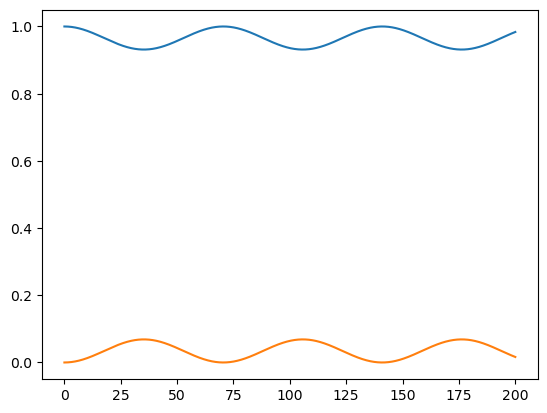

In [8]:
epsilons = [epsilon, epsilon_2]

num_modes = len(modes_1) + len(modes_2)
overlap_integrals = np.zeros((num_modes, num_modes), dtype=complex)
for i, mode_i in enumerate(chain(modes_1, modes_2)):
    for j, mode_j in enumerate(chain(modes_1, modes_2)):
        overlap_integrals[i, j] = mode_i.calculate_overlap(mode_j)

print("overlap", overlap_integrals)
# plt.imshow(np.abs(overlap_integrals))
# plt.colorbar()
# plt.show()

coupling_coefficients = np.zeros((num_modes, num_modes), dtype=complex)
for i, mode_i in enumerate(chain(modes_1, modes_2)):
    for j, mode_j in enumerate(chain(modes_1, modes_2)):
        coupling_coefficients[i, j] = (
            k0
            * speed_of_light
            * epsilon_0
            * mode_i.calculate_coupling_coefficient(
                mode_j, epsilons[(j // len(modes_1) + 1) % 2] - 1.444**2
            )
            * 0.5
        )


print(coupling_coefficients)
# plt.imshow(np.abs(coupling_coefficients))
# plt.colorbar()
# plt.show()

kappas = np.array(
    [
        [
            (
                coupling_coefficients[i, j]
                - overlap_integrals[i, (i + 1) % 2]
                * coupling_coefficients[(i + 1) % 2, j]
                / overlap_integrals[(i + 1) % 2, (i + 1) % 2]
            )
            / (
                1
                - overlap_integrals[0, 1]
                * overlap_integrals[1, 0]
                / (overlap_integrals[0, 0] * overlap_integrals[1, 1])
            )
            for i in range(2)
        ]
        for j in range(2)
    ]
)
print(kappas)

delta = 0.5 * (
    np.real(modes_1[0].n_eff) * k0 + kappas[1, 1] - (np.real(modes_2[0].n_eff) * k0 + kappas[0, 0])
)
print(delta, np.real(modes_1[0].n_eff) * k0, kappas[1, 1])

beta_c = (kappas[0, 1] * kappas[1, 0] + delta**2) ** 0.5

print(np.pi / (2 * beta_c))

eta = np.abs(kappas[1, 0] ** 2 / beta_c**2) * np.sin(beta_c * 1e3)
print("eta", eta, np.abs(kappas[1, 0] ** 2 / beta_c**2))

plt.plot(ts, 1 - np.abs(kappas[1, 0] ** 2 / beta_c**2 * np.sin(beta_c * ts) ** 2))
plt.plot(ts, np.abs(kappas[1, 0] ** 2 / beta_c**2 * np.sin(beta_c * ts) ** 2))
plt.show()

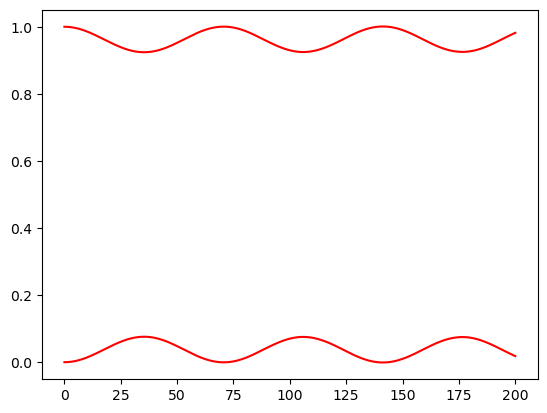

In [9]:
def fun(t, y):
    phase_matrix = [
        [
            np.exp(2j * np.pi / wavelength * (mode_i.n_eff - mode_j.n_eff) * t)
            for mode_j in chain(modes_1, modes_2)
        ]
        for mode_i in chain(modes_1, modes_2)
    ]
    matrix = (
        np.linalg.inv(overlap_integrals * phase_matrix)
        @ (coupling_coefficients * phase_matrix)
        * -1j
    )
    return (matrix @ y).ravel()


result = solve_ivp(fun, [0, length], np.array((1, 0), dtype=complex), t_eval=ts)
ys = result.y.T

plt.plot(ts, np.abs(np.array(ys)[:, 0]) ** 2, "r")
plt.plot(ts, 1 - np.abs(np.array(ys)[:, 0]) ** 2, "r")
# plt.plot(ts, np.array(ys).imag.reshape((-1,)+matrix.shape)@(1,0), 'g')
plt.show()

[0.021203149909950068, 0.9788107503909659]


C:\Users\blow\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


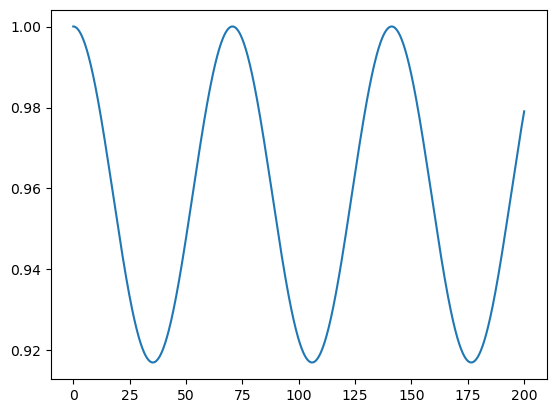

In [10]:
R = [np.abs(modes_1[0].calculate_overlap(mode_j) ** 2) for mode_j in modes_both]
print(R)
P = (
    R[0] ** 2
    + R[1] ** 2
    + 2
    * R[0]
    * R[1]
    * np.cos(2 * np.pi / wavelength * (modes_both[0].n_eff - modes_both[1].n_eff) * ts)
)

plt.plot(ts, P)
plt.show()

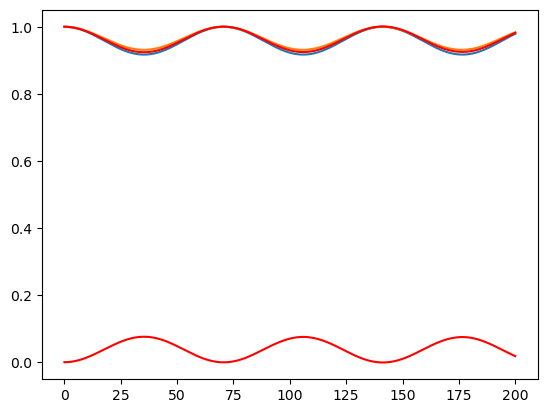

In [11]:
plt.plot(ts, P)


plt.plot(ts, 1 - np.abs(kappas[1, 0] ** 2 / beta_c**2) * np.sin(beta_c * ts) ** 2)

plt.plot(ts, np.abs(np.array(ys)[:, 0]) ** 2, "r")
plt.plot(ts, 1 - np.abs(np.array(ys)[:, 0]) ** 2, "r")
# plt.plot(ts, np.array(ys).imag.reshape((-1,)+matrix.shape)@(1,0), 'g')
plt.show()